# Test de différents modèles

## Modèle Explicatif (Taux vs Facteurs Environnementaux/Économiques)

### 🔄 Améliorations par rapport à NbCorrected.ipynb :

1. **Imputation sophistiquée** : Utilisation de `IterativeImputer` (via `data_preparation.py`) au lieu de la simple médiane
   - Forward/backward fill par pays pour les séries temporelles
   - IterativeImputer pour les valeurs manquantes restantes (méthode plus robuste)

2. **Encodage automatique** : Les pays (`Country Code`) sont automatiquement encodés en one-hot lors de l'imputation

3. **Pas de SMOTE** : Pour l'instant, nous n'utilisons pas SMOTE (commenté) pour évaluer les performances sans sur-échantillonnage

4. **Architecture simplifiée** : Pas de pipeline imbriqué - les données sont pré-traitées avant la modélisation


In [1]:
# Définir le chemin de base
BASE_PATH = "/mnt/c/Users/ala78/OneDrive - HESSO/BA5/GML/data-gml-health/Refined"

# Définir le dossier
folder_name = "1021"

# Définir le nom du fichier
file_name = "COPD_prevalence_rate"

# Définir le format du fichier (csv, parquet, ...)
file_format = "csv"

In [2]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Ajouter le dossier parent au path pour importer data_preparation
project_root = Path.cwd().parent    
sys.path.append(str(project_root.resolve()))

import COPD.data_preparation as data_preparation

# Chargement des données (adaptez le chemin selon votre fichier)
df = pd.read_csv(f"{BASE_PATH}/{folder_name}/{file_name}.{file_format}")

# Affichage des premières lignes pour vérifier les noms de colonnes
print("Aperçu des données :")
print(df.head())
print("\nNoms des colonnes :")
print(df.columns.tolist())
print("\nTypes de données :")
print(df.dtypes)


Aperçu des données :
      Measure Country Name                                Disease Metric  \
0  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
1  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
2  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
3  Prevalence        China  Chronic obstructive pulmonary disease   Rate   
4  Prevalence        China  Chronic obstructive pulmonary disease   Rate   

   Year        Value Country Code  \
0  2015  1588.006576          IDN   
1  2017  1646.266156          IDN   
2  2018  1680.660819          IDN   
3  2013  3138.935866          CHN   
4  2014  3190.618304          CHN   

  Access to clean fuels and technologies for cooking (% of population)  \
0                                               67.3                     
1                                               75.5                     
2                                               78.9                     
3  

In [3]:
df.shape

(353, 38)

### Étape 1 : Création de la variable cible (Y)

Au lieu de prédire le *changement* (Augmente/Diminue), nous allons prédire le *niveau* du taux lui-même.
Nous divisons le taux `Value` en 3 catégories (quantiles) pour équilibrer les classes :
- 0 : Faible
- 1 : Moyen
- 2 : Élevé

In [4]:
# Utilisation de qcut pour diviser les données en 3 quantiles (tertiles)
# Cela garantit une distribution à peu près égale des classes
try:
    df['Y_class'] = pd.qcut(df['Value'], q=3, labels=[0, 1, 2])
    df['Y_label'] = pd.qcut(df['Value'], q=3, labels=['Faible', 'Moyen', 'Élevé'])
except ValueError as e:
    print(f"Avertissement lors du qcut : {e}. Il peut y avoir des valeurs dupliquées.")
    # En cas d'échec (par exemple, trop de valeurs identiques), on force
    df['Y_class'] = pd.qcut(df['Value'], q=3, labels=[0, 1, 2], duplicates='drop')
    df['Y_label'] = pd.qcut(df['Value'], q=3, labels=['Faible', 'Moyen', 'Élevé'], duplicates='drop')

print("✓ Variable cible 'Y_class' (0=Faible, 1=Moyen, 2=Élevé) créée.")
print("\nDistribution de la nouvelle variable cible :")
print(df['Y_label'].value_counts())

print("\nExemple de données avec la nouvelle cible :")
print(df[['Country Name', 'Year', 'Value', 'Y_class', 'Y_label']].head())

✓ Variable cible 'Y_class' (0=Faible, 1=Moyen, 2=Élevé) créée.

Distribution de la nouvelle variable cible :
Y_label
Faible    118
Élevé     118
Moyen     117
Name: count, dtype: int64

Exemple de données avec la nouvelle cible :
  Country Name  Year        Value Y_class Y_label
0    Indonesia  2015  1588.006576       0  Faible
1    Indonesia  2017  1646.266156       0  Faible
2    Indonesia  2018  1680.660819       0  Faible
3        China  2013  3138.935866       0  Faible
4        China  2014  3190.618304       0  Faible


### Étape 1.5 : Préparation et Imputation des Données

Nous allons utiliser les fonctions de `data_preparation.py` pour :
1. Préprocesser les données (remplacer '..' et 'nan' par NaN)
2. Imputer les valeurs manquantes avec la méthode IterativeImputer (plus sophistiquée que la médiane simple)


In [5]:
# Sauvegarder Y_class et Y_label avant l'imputation
y_class_saved = df['Y_class'].copy()
y_label_saved = df['Y_label'].copy()

# Définir uniquement les colonnes à EXCLURE
# (Ce sont les métadonnées et les cibles)
cols_to_exclude = [
    'Measure', 
    'Country Name', 
    'Disease', 
    'Metric', 
    'Y_class', 
    'Y_label'
]

# Sélectionner les colonnes pour l'imputation
df_for_imputation = df.drop(columns=cols_to_exclude).copy()

print("\n⏳ Étape 1/2 : Preprocessing (remplacement de '..' et 'nan' par NaN)...")
df_prepared = data_preparation.preprocessing(df_for_imputation)

print(f"Nombre de NaN après preprocessing :")
print(df_prepared.isnull().sum().sum())

print("\n⏳ Étape 2/2 : Imputation des valeurs manquantes avec IterativeImputer...")
print("⚠️ Cette étape peut prendre quelques minutes...")
df_imputed = data_preparation.impute_nans(df_prepared)

print("\n✓ Imputation terminée !")
print(f"Nombre de NaN après imputation : {df_imputed.isnull().sum().sum()}")

# Récupérer les index originaux et ajouter Y_class et Y_label
df_imputed.index = df.index
df_imputed['Y_class'] = y_class_saved
df_imputed['Y_label'] = y_label_saved

print("\n✓ Données préparées et imputées avec succès !")
print(f"Forme finale : {df_imputed.shape}")



⏳ Étape 1/2 : Preprocessing (remplacement de '..' et 'nan' par NaN)...
Nombre de NaN après preprocessing :
675

⏳ Étape 2/2 : Imputation des valeurs manquantes avec IterativeImputer...
⚠️ Cette étape peut prendre quelques minutes...
📊 Colonnes détectées pour l'imputation : 32 colonnes

✓ Imputation terminée !
Nombre de NaN après imputation : 0

✓ Données préparées et imputées avec succès !
Forme finale : (353, 81)


/home/aladin/gml/GML_RespiratoryDiseases/COPD/data_preparation.py:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda g: g.ffill().bfill())


In [6]:
df.shape

(353, 40)

### Étape 1.6 : Feature Engineering - Normalisation des Variables

Pour éviter les biais de corrélation avec la taille des pays, nous créons des features normalisées :
1. **Densité de population** : Remplace la surface (corrélée au pays) par une métrique démographique
2. **Suppression des colonnes totales redondantes** : Élimine les totaux quand une version per capita existe déjà (ex: garder "GDP per capita", supprimer "GDP total")
3. **Ratios per capita** : Transforme des valeurs absolues en valeurs normalisées par habitant
4. **Traitement des variables météo** : Supprime les températures redondantes (skt, d2m corrélées à t2m) et arrondit t2m et sst pour réduire le biais de précision

In [7]:
# FEATURE ENGINEERING : Création de ratios par rapport à la population

print("="*80)
print("LISTE DE TOUTES LES COLONNES DISPONIBLES POUR FEATURE ENGINEERING")
print("="*80)

# Exclure les colonnes de métadonnées et cibles
excluded_for_display = ['Value', 'Y_class', 'Y_label', 'Country Code', 'Year']
available_cols = [col for col in df_imputed.columns 
                  if col not in excluded_for_display and not col.startswith('Country Code_')]

# Afficher toutes les colonnes disponibles
for i, col in enumerate(available_cols, 1):
    print(f"{i:2d}. {col}")

print(f"\n{'='*80}")
print(f"Total : {len(available_cols)} colonnes disponibles")
print("="*80)

LISTE DE TOUTES LES COLONNES DISPONIBLES POUR FEATURE ENGINEERING
 1. Access to clean fuels and technologies for cooking (% of population)
 2. Access to electricity (% of population)
 3. Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)
 4. Compulsory education, duration (years)
 5. GDP (current US$)
 6. GDP per capita (constant 2015 US$)
 7. Gini index
 8. Life expectancy at birth, total (years)
 9. Mortality rate, infant (per 1,000 live births)
10. People using at least basic sanitation services (% of population)
11. Population, total
12. Poverty headcount ratio at national poverty lines (% of population)
13. Renewable electricity output (% of total electricity output)
14. Surface area (sq. km)
15. Unemployment, total (% of total labor force) (national estimate)
16. Total area (Square Km)
17. PM10_ConcentrationAvg
18. PM25_ConcentrationAvg
19. NO2_ConcentrationAvg
20. Greenhouse gases (Kg CO2-equivalent Per Person)
21. Sulphur oxides (tonnes)
22. Total sales 

In [8]:
# CONFIGURATION : Définir manuellement les colonnes à normaliser par la population
# Ajoutez ou retirez des colonnes selon vos besoins

# Colonnes à transformer en ratio par habitant (per capita)
# Ces colonnes seront divisées par 'Population, total' et la colonne originale sera supprimée
cols_to_normalize_by_population = [
    'Sulphur oxides (tonnes)',
    'Total sales of agricultural pesticides (tonnes)',
    # Ajoutez d'autres colonnes ici selon vos besoins
]

# Colonnes TOTALES à supprimer car elles ont déjà une version per capita
# (ex: 'GDP per capita' existe déjà, donc on supprime 'GDP (current US$)' qui est redondant)
cols_to_drop_total_have_per_capita = [
    'GDP (current US$)',
    'Surface area (sq. km)',
    'Total area (Square Km)',
    'Population, total',  # Sera utilisée pour les calculs mais supprimée à la fin
    # Ajoutez d'autres colonnes TOTALES ici selon vos besoins
]

# Colonnes météo redondantes à supprimer (corrélation = 1 avec t2m)
cols_meteo_redundant = ['skt', 'd2m']

# Colonnes météo à arrondir (trop précises, causent du biais)
cols_meteo_to_round = ['t2m', 'sst']

print("📊 FEATURE ENGINEERING - NORMALISATION DES VARIABLES")
print("="*80)

# ========== ÉTAPE 1 : CALCUL DE LA DENSITÉ DE POPULATION ==========
print("\n[1/4] Calcul de la Densité de Population")
print("-" * 80)

if 'Population, total' in df_imputed.columns and 'Surface area (sq. km)' in df_imputed.columns:
    # Calculer la densité (éviter division par zéro)
    df_imputed['Population Density (per sq. km)'] = (
        df_imputed['Population, total'] / df_imputed['Surface area (sq. km)'].replace(0, np.nan)
    )
    
    print(f"✓ Densité calculée : Population Density (per sq. km)")
    print(f"  Stats - Min: {df_imputed['Population Density (per sq. km)'].min():.2f} | "
          f"Max: {df_imputed['Population Density (per sq. km)'].max():.2f} | "
          f"Mean: {df_imputed['Population Density (per sq. km)'].mean():.2f} hab/km²")
else:
    print("⚠️  Colonnes manquantes - Densité non calculée")

# ========== ÉTAPE 2 : CRÉATION DE RATIOS PER CAPITA ==========
print(f"\n[2/4] Création de Ratios Per Capita")
print("-" * 80)
print(f"Colonnes à normaliser : {len(cols_to_normalize_by_population)}\n")

if 'Population, total' not in df_imputed.columns:
    print("❌ ERREUR : La colonne 'Population, total' n'existe pas !")
    print("   Impossible de calculer les ratios.")
else:
    # Créer les ratios
    created_features = []
    removed_features = []
    
    for col in cols_to_normalize_by_population:
        if col in df_imputed.columns:
            # Créer le nom de la nouvelle colonne
            new_col_name = f"{col} (per capita)"
            
            # Calculer le ratio (éviter division par zéro)
            df_imputed[new_col_name] = df_imputed[col] / df_imputed['Population, total'].replace(0, np.nan)
            
            # Supprimer l'ancienne colonne
            df_imputed = df_imputed.drop(columns=[col])
            
            created_features.append(new_col_name)
            removed_features.append(col)
            
            print(f"✓ {col}")
            print(f"  → Créé : {new_col_name}")
            print(f"  → Supprimé : {col}\n")
        else:
            print(f"⚠️  {col} - NON TROUVÉE (ignorée)\n")

# ========== ÉTAPE 3 : SUPPRESSION DES COLONNES TOTALES (ont déjà une version per capita) ==========
print(f"\n[3/4] Suppression des Colonnes Totales (ont déjà une version per capita)")
print("-" * 80)

dropped_totals = []
for col in cols_to_drop_total_have_per_capita:
    if col in df_imputed.columns:
        df_imputed = df_imputed.drop(columns=[col])
        dropped_totals.append(col)
        print(f"✓ Supprimé : {col}")
    else:
        print(f"⚠️  {col} - NON TROUVÉE (ignorée)")

if dropped_totals:
    print(f"\n  Total colonnes totales supprimées : {len(dropped_totals)}")
else:
    print("\n  Aucune colonne à supprimer")

# ========== ÉTAPE 4 : TRAITEMENT DES VARIABLES MÉTÉOROLOGIQUES ==========
print(f"\n[4/4] Traitement des Variables Météorologiques")
print("-" * 80)

# Suppression des températures redondantes (corrélation = 1 avec t2m)
dropped_meteo = []
for col in cols_meteo_redundant:
    if col in df_imputed.columns:
        df_imputed = df_imputed.drop(columns=[col])
        dropped_meteo.append(col)
        print(f"✓ Supprimé (redondant avec t2m) : {col}")
    else:
        print(f"⚠️  {col} - NON TROUVÉE (ignorée)")

# Arrondissement des températures trop précises
rounded_meteo = []
for col in cols_meteo_to_round:
    if col in df_imputed.columns:
        print(f"📊 {col} - Avant arrondissement:")
        print(f"  Exemples de valeurs: {df_imputed[col].head(10).tolist()}")
        print(f"  Nombre de valeurs uniques: {df_imputed[col].nunique()}")
        
        df_imputed[col] = df_imputed[col].round(2)
        rounded_meteo.append(col)
        
        print(f"✓ Arrondi à 1 décimale : {col}")
        print(f"  Exemples après arrondissement: {df_imputed[col].head(10).tolist()}")
        print(f"  Nombre de valeurs uniques après arrondissement: {df_imputed[col].nunique()}\n")
    else:
        print(f"⚠️  {col} - NON TROUVÉE (ignorée)")

if dropped_meteo or rounded_meteo:
    print(f"\n  Colonnes météo supprimées : {len(dropped_meteo)}")
    print(f"  Colonnes météo arrondies : {len(rounded_meteo)}")
else:
    print("\n  Aucune modification météo")

print("\n" + "="*80)
print("📈 RÉSUMÉ DES TRANSFORMATIONS")
print("="*80)
print(f"Features créées  : {len(created_features) + 1}")  # +1 pour la densité
print(f"Features supprimées : {len(removed_features) + len(dropped_totals) + len(dropped_meteo)}")
print(f"  - Colonnes normalisées (remplacées) : {len(removed_features)}")
print(f"  - Colonnes totales (ont déjà version per capita) : {len(dropped_totals)}")
print(f"  - Colonnes météo redondantes : {len(dropped_meteo)}")
print(f"Features arrondies : {len(rounded_meteo)} (températures)")
print(f"Forme du DataFrame : {df_imputed.shape}")
print("="*80)

📊 FEATURE ENGINEERING - NORMALISATION DES VARIABLES

[1/4] Calcul de la Densité de Population
--------------------------------------------------------------------------------
✓ Densité calculée : Population Density (per sq. km)
  Stats - Min: 2.94 | Max: 516.25 | Mean: 143.85 hab/km²

[2/4] Création de Ratios Per Capita
--------------------------------------------------------------------------------
Colonnes à normaliser : 2

✓ Sulphur oxides (tonnes)
  → Créé : Sulphur oxides (tonnes) (per capita)
  → Supprimé : Sulphur oxides (tonnes)

✓ Total sales of agricultural pesticides (tonnes)
  → Créé : Total sales of agricultural pesticides (tonnes) (per capita)
  → Supprimé : Total sales of agricultural pesticides (tonnes)


[3/4] Suppression des Colonnes Totales (ont déjà une version per capita)
--------------------------------------------------------------------------------
✓ Supprimé : GDP (current US$)
✓ Supprimé : Surface area (sq. km)
✓ Supprimé : Total area (Square Km)
✓ Supprimé : 

### Étape 2 : Définition des Features (X)

Nous utilisons toutes les colonnes brutes (environnementales, économiques, etc.) pour expliquer `Y`.

**Note importante** : Après l'imputation avec `data_preparation.impute_nans()`, les colonnes `Country Code` ont été encodées en one-hot encoding (plusieurs colonnes `Country Code_XXX`). C'est pourquoi nous avons maintenant beaucoup plus de features qu'initialement.


In [9]:
# Définition des features (X) et de la cible (y)

# Définir les colonnes qui ne sont PAS des features
# (ce sont vos cibles et la cible d'origine)
cols_to_exclude = ['Value', 'Y_class', 'Y_label']

# features_for_model : toutes les colonnes SAUF les cibles, Year, et Country Code encodés
all_columns = df_imputed.drop(columns=cols_to_exclude).columns.tolist()

# Exclure Year et les colonnes Country Code_XXX pour éviter les biais
features_for_model = [col for col in all_columns 
                      if col != 'Year' and not col.startswith('Country Code_')]

print(f"📊 Filtrage des features :")
print(f"   Total de colonnes disponibles : {len(all_columns)}")
print(f"   Colonnes Country Code exclues : {sum(1 for col in all_columns if col.startswith('Country Code_'))}")
print(f"   Year exclu : {'Year' in all_columns}")
print(f"   Features finales pour modélisation : {len(features_for_model)}")

# Créer le DataFrame pour la modélisation (utiliser df_imputed au lieu de df)
df_model = df_imputed[features_for_model + ['Y_class']].copy()

# Nettoyer les NaN de la cible (s'il y en a eu lors du qcut)
df_model = df_model.dropna(subset=['Y_class'])

print(f"\n✓ Taille du DataFrame pour modélisation : {df_model.shape}")
print(f"✓ Nombre de NaN dans df_model : {df_model.isnull().sum().sum()}")
print(f"\n⚠️ Note : Year et Country Code ont été EXCLUS pour éviter les biais géographiques/temporels")


📊 Filtrage des features :
   Total de colonnes disponibles : 73
   Colonnes Country Code exclues : 46
   Year exclu : True
   Features finales pour modélisation : 26

✓ Taille du DataFrame pour modélisation : (353, 27)
✓ Nombre de NaN dans df_model : 0

⚠️ Note : Year et Country Code ont été EXCLUS pour éviter les biais géographiques/temporels


In [10]:
df_imputed.shape

(353, 76)

### Étape 3 : Configuration des Modèles

**Différence avec NbCorrected.ipynb** :
- ✅ Les données sont **déjà imputées** avec `IterativeImputer` (plus sophistiqué que la médiane)
- ✅ Pas besoin de pipeline `ImbPipeline` avec imputer/scaler/SMOTE
- ✅ Pour la Logistic Regression : standardisation des données (nécessaire pour ce modèle)
- ✅ Pour Random Forest et XGBoost : données brutes (ces modèles tree-based n'ont pas besoin de standardisation)
- ⚠️ SMOTE est désactivé pour l'instant (à réactiver si nécessaire)


In [11]:
# Import des bibliothèques pour SMOTE et classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("✓ Bibliothèques importées avec succès pour la classification multi-classe !")
print("="*80)


✓ Bibliothèques importées avec succès pour la classification multi-classe !


In [12]:
# Définition de X et y
X = df_model.drop('Y_class', axis=1)
y = df_model['Y_class'].astype(int)

# Vérifier que toutes les colonnes sont déjà numériques (après l'imputation)
print("Types de données dans X :")
print(X.dtypes.value_counts())

# Vérifier les NaN
print(f"\nNombre total de NaN dans X : {X.isnull().sum().sum()}")
if X.isnull().sum().sum() > 0:
    print("⚠️ Colonnes avec des NaN :")
    print(X.isnull().sum()[X.isnull().sum() > 0])

# Noms des features finales
feature_names = X.columns.tolist()
print(f"\n✓ {len(feature_names)} features prêtes pour la modélisation")

# Division Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"\nDistribution de la cible dans l'ensemble d'entraînement :")
print(y_train.value_counts(normalize=True))

print("\n✓ Données train/test prêtes (pas besoin de pipeline de prétraitement)")
print(f"   X_train shape : {X_train.shape}")
print(f"   X_test shape  : {X_test.shape}")


Types de données dans X :
float64    26
Name: count, dtype: int64

Nombre total de NaN dans X : 0

✓ 26 features prêtes pour la modélisation

Distribution de la cible dans l'ensemble d'entraînement :
Y_class
0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64

✓ Données train/test prêtes (pas besoin de pipeline de prétraitement)
   X_train shape : (282, 26)
   X_test shape  : (71, 26)


In [13]:
X.shape

(353, 26)

In [14]:
# Définition des 3 modèles pour CLASSIFICATION MULTI-CLASSE

print("="*80)
print("CONFIGURATION DES MODÈLES POUR CLASSIFICATION MULTI-CLASSE (3 CLASSES)")
print("="*80)

# Les données sont déjà imputées et prétraitées, nous n'avons plus besoin de pipeline
# Pour la Logistic Regression, nous allons quand même standardiser
from sklearn.preprocessing import StandardScaler

# Pour Logistic Regression : on va standardiser
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models_with_smote = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        multi_class='auto' # Gère les 3 classes
    ),
    
    'Random Forest': RandomForestClassifier(
        random_state=42, 
        n_estimators=100
    ),
    
    'XGBoost': XGBClassifier(
        objective='multi:softmax',  # Objectif multi-classe
        num_class=3,              # Nombre de classes
        random_state=42, 
        eval_metric='mlogloss'
    )
}

print("\n✓ Modèles créés pour 3 classes :")
for model_name in models_with_smote.keys():
    print(f"  - {model_name}")
    
print("\n⚠️ Note : Les données sont déjà imputées avec IterativeImputer")
print("   Logistic Regression utilisera des données standardisées")
print("   Random Forest et XGBoost utiliseront les données brutes")
print("="*80)


CONFIGURATION DES MODÈLES POUR CLASSIFICATION MULTI-CLASSE (3 CLASSES)

✓ Modèles créés pour 3 classes :
  - Logistic Regression
  - Random Forest
  - XGBoost

⚠️ Note : Les données sont déjà imputées avec IterativeImputer
   Logistic Regression utilisera des données standardisées
   Random Forest et XGBoost utiliseront les données brutes


### Étape 4 : Entraînement et Évaluation des Modèles

In [15]:
# Dictionnaire pour stocker les résultats
results_with_smote = {}

print("="*80)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES - (3 CLASSES)")
print("="*80)

# Labels des classes pour les rapports
class_labels = ['Faible (0)', 'Moyen (1)', 'Élevé (2)']

for model_name, model in models_with_smote.items():
    print(f"\n{'='*80}")
    print(f"🔄 Modèle : {model_name}")
    print('='*80)
    
    # Entraînement
    print(f"⏳ Entraînement en cours...")
    
    # Logistic Regression utilise les données standardisées
    if model_name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Random Forest et XGBoost utilisent les données brutes
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    print(f"✓ Entraînement terminé")
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    # Utiliser 'weighted' pour F1, Precision, Recall pour la moyenne globale
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Stockage des résultats
    results_with_smote[model_name] = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'y_pred': y_pred
    }
    
    # Affichage des métriques globales
    print(f"\n📊 Métriques globales (pondérées) :")
    print(f"   Accuracy  : {accuracy:.4f}")
    print(f"   Precision : {precision:.4f}")
    print(f"   Recall    : {recall:.4f}")
    print(f"   F1-Score  : {f1:.4f}")
    
    # Rapport de classification détaillé pour les 3 classes
    print(f"\n📋 Rapport de Classification (3 classes) :")
    print(classification_report(y_test, y_pred, 
                                target_names=class_labels,
                                zero_division=0))

print(f"\n{'='*80}")
print("✓ Tous les modèles ont été entraînés et évalués sur 3 classes !")
print('='*80)


ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES - (3 CLASSES)

🔄 Modèle : Logistic Regression
⏳ Entraînement en cours...
✓ Entraînement terminé

📊 Métriques globales (pondérées) :
   Accuracy  : 0.5915
   Precision : 0.5971
   Recall    : 0.5915
   F1-Score  : 0.5927

📋 Rapport de Classification (3 classes) :
              precision    recall  f1-score   support

  Faible (0)       0.62      0.62      0.62        24
   Moyen (1)       0.65      0.57      0.60        23
   Élevé (2)       0.52      0.58      0.55        24

    accuracy                           0.59        71
   macro avg       0.60      0.59      0.59        71
weighted avg       0.60      0.59      0.59        71


🔄 Modèle : Random Forest
⏳ Entraînement en cours...


/home/aladin/.gml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ Entraînement terminé

📊 Métriques globales (pondérées) :
   Accuracy  : 0.7606
   Precision : 0.7761
   Recall    : 0.7606
   F1-Score  : 0.7635

📋 Rapport de Classification (3 classes) :
              precision    recall  f1-score   support

  Faible (0)       0.95      0.79      0.86        24
   Moyen (1)       0.68      0.83      0.75        23
   Élevé (2)       0.70      0.67      0.68        24

    accuracy                           0.76        71
   macro avg       0.77      0.76      0.76        71
weighted avg       0.78      0.76      0.76        71


🔄 Modèle : XGBoost
⏳ Entraînement en cours...
✓ Entraînement terminé

📊 Métriques globales (pondérées) :
   Accuracy  : 0.7746
   Precision : 0.7884
   Recall    : 0.7746
   F1-Score  : 0.7783

📋 Rapport de Classification (3 classes) :
              precision    recall  f1-score   support

  Faible (0)       0.95      0.79      0.86        24
   Moyen (1)       0.72      0.78      0.75        23
   Élevé (2)       0.69      

### Étape 5 : Matrices de Confusion

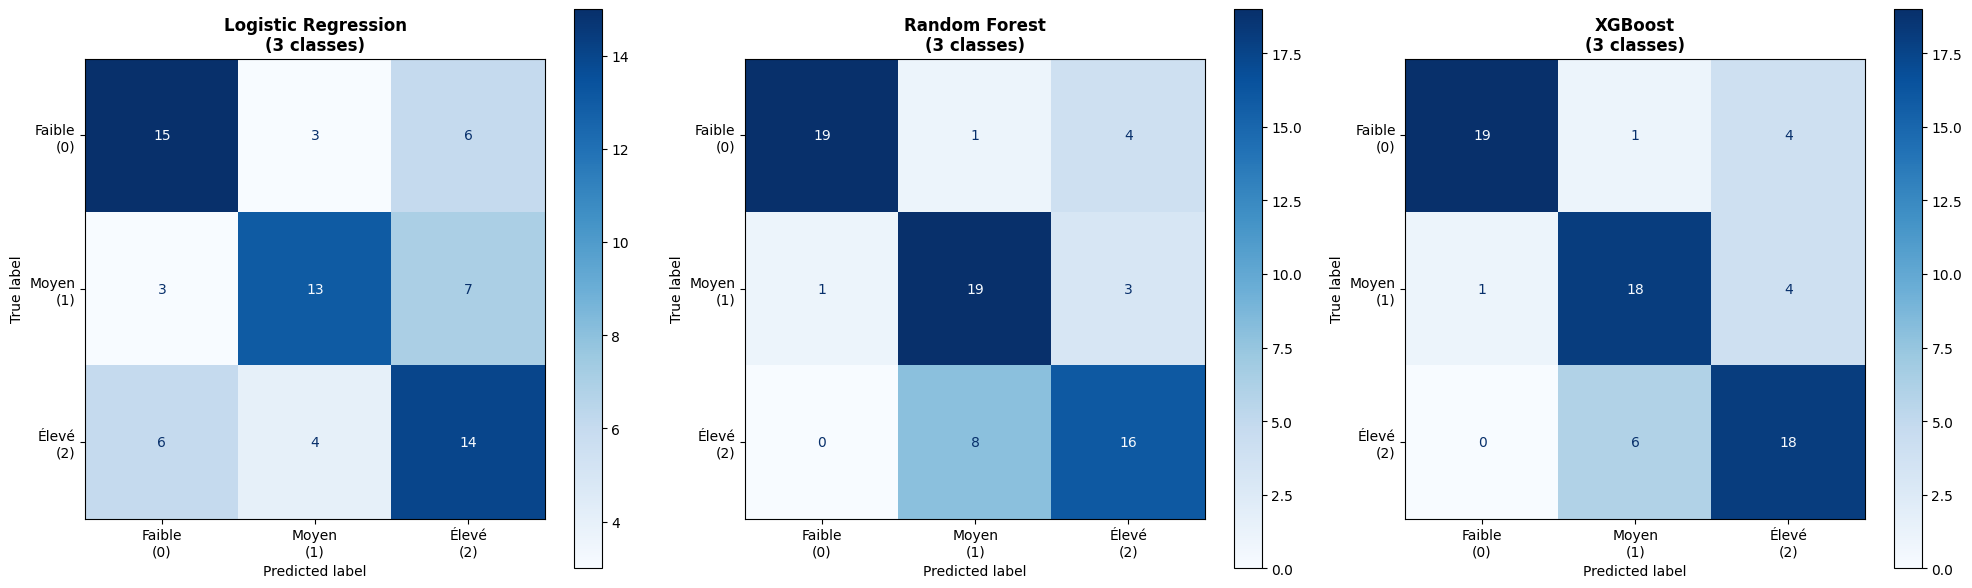

✓ Matrices de confusion affichées pour les 3 classes


In [16]:
# Affichage des matrices de confusion pour les 3 modèles (3 CLASSES)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Labels pour les 3 classes
display_labels = ['Faible\n(0)', 'Moyen\n(1)', 'Élevé\n(2)']

for idx, (model_name, results) in enumerate(results_with_smote.items()):
    y_pred = results['y_pred']
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    
    # Affichage
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=display_labels
    )
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name}\n(3 classes)', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

print("✓ Matrices de confusion affichées pour les 3 classes")
print("="*80)


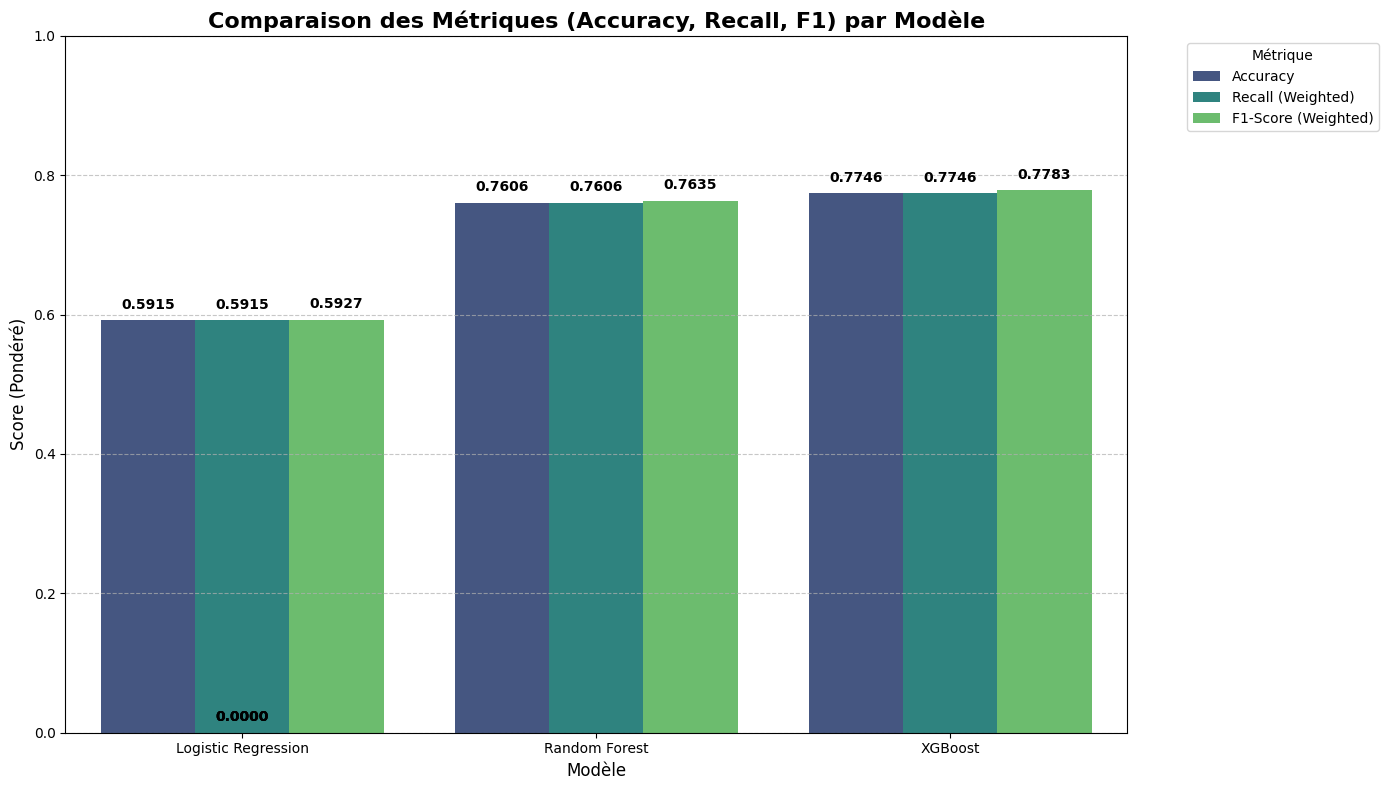

Graphique de comparaison des métriques généré et sauvegardé sous 'model_metrics_comparison.png'


In [17]:
# 1. Extraire les données de 'results_with_smote' (créé dans la cellule 40)
# Assurez-vous que la cellule 40 a été exécutée.
data_list = []
for model_name, metrics in results_with_smote.items():
    data_list.append({
        'Modèle': model_name,
        'Accuracy': metrics['accuracy'],
        'Recall (Weighted)': metrics['recall_weighted'],
        'F1-Score (Weighted)': metrics['f1_weighted']
    })

# 2. Convertir en DataFrame
df_results = pd.DataFrame(data_list)

# 3. Mettre en format long (melt) pour Seaborn
df_melted = df_results.melt(id_vars='Modèle', var_name='Métrique', value_name='Score')

# 4. Créer le graphique à barres groupées
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_melted,
    x='Modèle',
    y='Score',
    hue='Métrique',
    palette='viridis'
)

# 5. Améliorer la lisibilité
plt.title('Comparaison des Métriques (Accuracy, Recall, F1) par Modèle', fontsize=16, fontweight='bold')
plt.ylabel('Score (Pondéré)', fontsize=12)
plt.xlabel('Modèle', fontsize=12)

# Forcer l'axe Y à commencer à 0 et finir à 1 pour respecter les proportions.
plt.ylim(0, 1)

# Ajouter les étiquettes de données (placées légèrement au-dessus des barres)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.4f}', # 4 décimales
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        xytext=(0, 6),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

plt.legend(title='Métrique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Sauvegarder le graphique
plt.savefig("model_metrics_comparison.png")
plt.show()

print("Graphique de comparaison des métriques généré et sauvegardé sous 'model_metrics_comparison.png'")

## Étape 6 : Analyse de l'Importance des Features

Maintenant, nous pouvons voir quels facteurs (économiques, environnementaux, etc.) ont le plus d'influence sur la prédiction du taux de BPCO.

In [18]:
# Extraction de l'importance des features pour chaque modèle

# Dictionnaire pour stocker les importances
feature_importances = {}

# Pour chaque modèle, extraire l'importance des features
for model_name, model in models_with_smote.items():
    # Récupérer directement le modèle (plus de pipeline)
    if model_name == 'Logistic Regression':
        # Pour la régression logistique multi-classe, on prend la moyenne des coeffs absolus
        importances = np.abs(model.coef_).mean(axis=0)
        
    elif model_name == 'Random Forest':
        importances = model.feature_importances_
        
    elif model_name == 'XGBoost':
        importances = model.feature_importances_
    
    # S'assurer que les dimensions correspondent
    if len(importances) != len(feature_names):
        # Utiliser seulement les features qui existent
        min_len = min(len(importances), len(feature_names))
        importances = importances[:min_len]
    
    # Stocker les importances
    feature_importances[model_name] = importances

print("✓ Analyse de l'importance des features calculée")


✓ Analyse de l'importance des features calculée


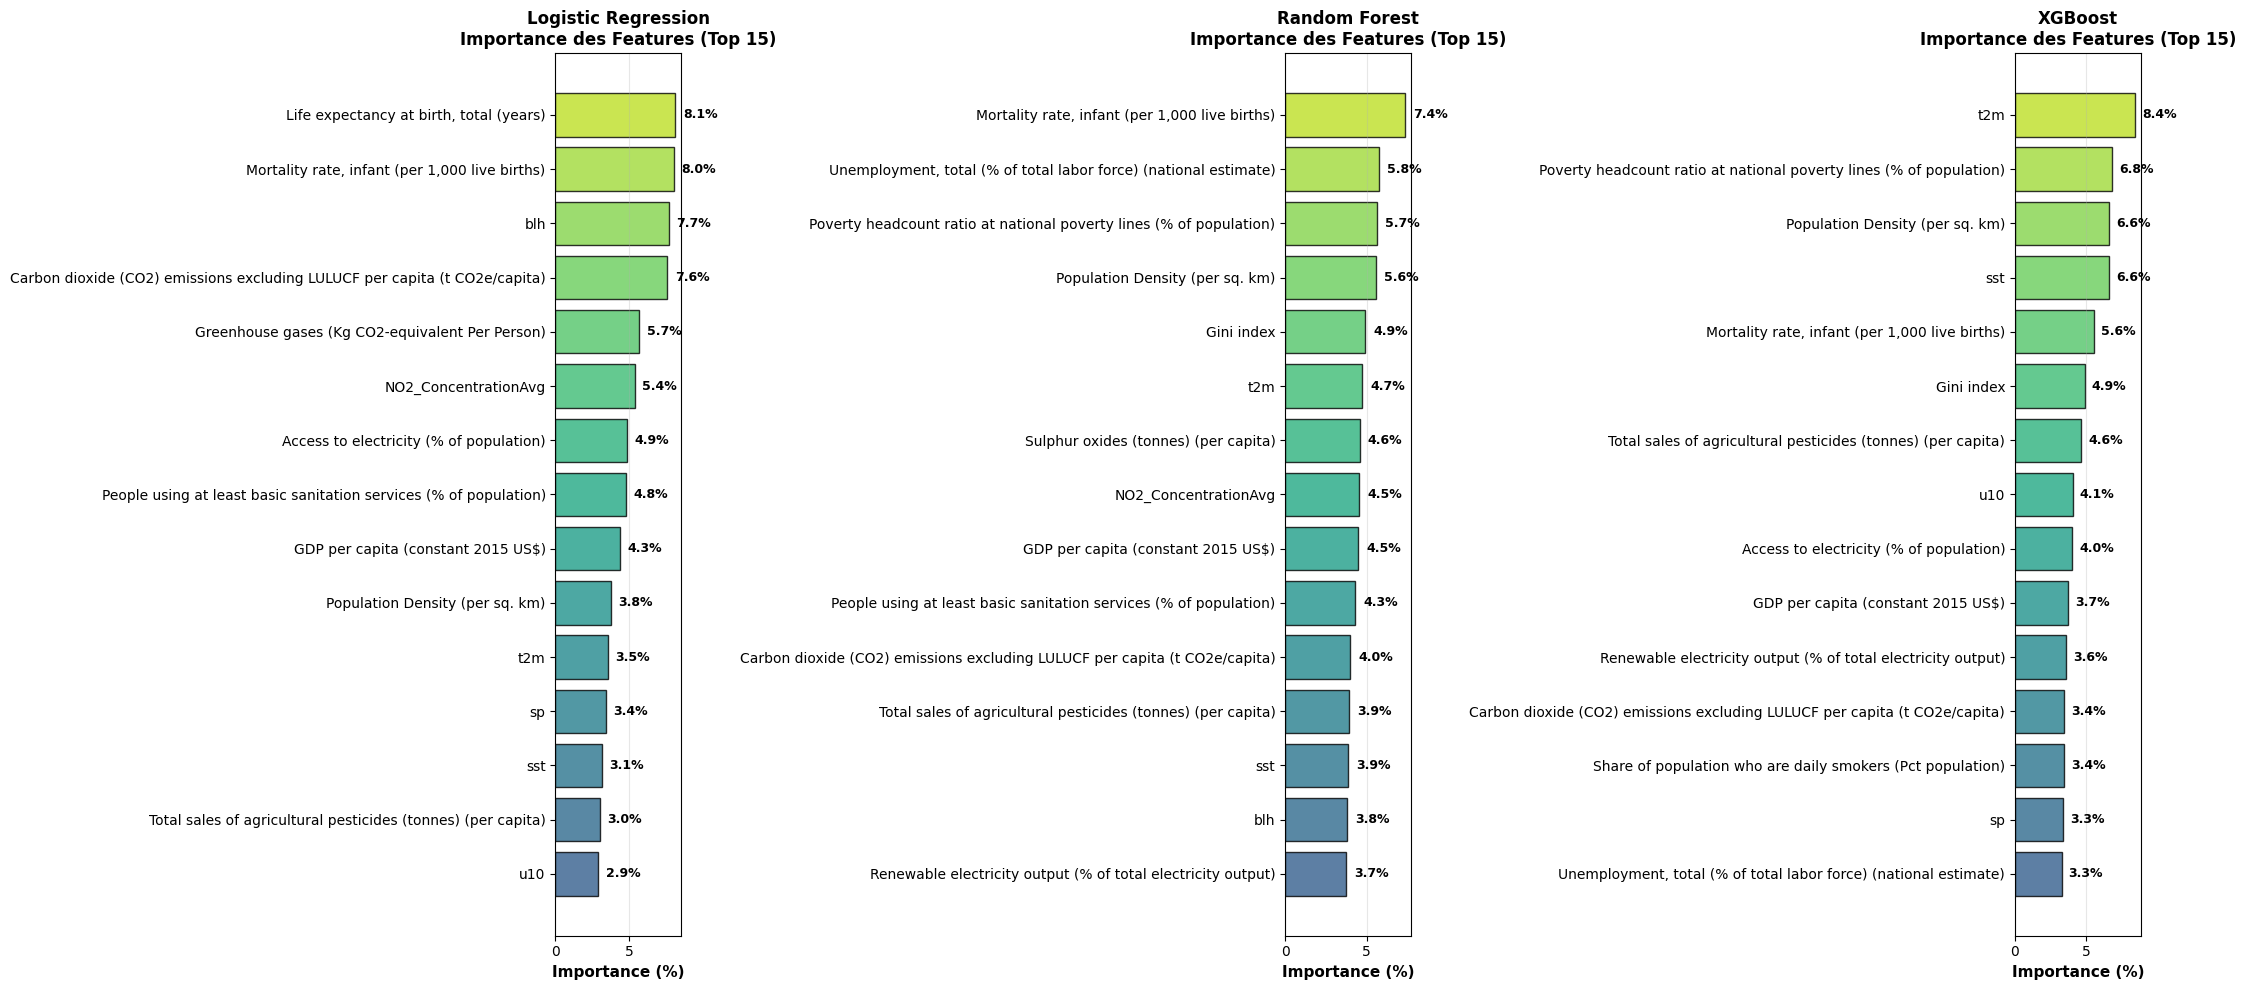

In [19]:
# Visualisation de l'importance des features (Top 15) pour chaque modèle

fig, axes = plt.subplots(1, 3, figsize=(22, 10)) 

for idx, (model_name, importances) in enumerate(feature_importances.items()):
    # Déterminer les noms de features à utiliser
    if len(importances) != len(feature_names):
        min_len = min(len(importances), len(feature_names))
        current_feature_names = feature_names[:min_len]
    else:
        current_feature_names = feature_names
    
    # Créer DataFrame et trier
    importance_df = pd.DataFrame({
        'Feature': current_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15) # Top 15
    
    # Inverser pour affichage horizontal
    importance_df = importance_df.sort_values('Importance', ascending=True)
    
    # Normaliser les importances en pourcentages
    total_importance = importances.sum() # Somme totale de TOUTES les features
    importance_pct = (importance_df['Importance'] / total_importance) * 100
    
    # Couleurs
    colors_palette = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
    
    # Créer le graphique horizontal
    bars = axes[idx].barh(importance_df['Feature'], importance_pct, 
                          color=colors_palette, alpha=0.8, edgecolor='black')
    
    axes[idx].set_xlabel('Importance (%)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{model_name}\nImportance des Features (Top 15)', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for bar, pct in zip(bars, importance_pct):
        width = bar.get_width()
        axes[idx].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                      f'{pct:.1f}%', 
                      ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


In [20]:
# Comparaison de l'importance des features entre modèles

# Déterminer le nombre de features à utiliser (prendre le minimum)
min_features = min(len(importances) for importances in feature_importances.values())
current_feature_names = feature_names[:min_features]

# Créer un DataFrame pour comparer les importances
comparison_data = {'Feature': current_feature_names}

for model_name, importances in feature_importances.items():
    # Normaliser en pourcentages (utiliser seulement les min_features premières)
    importances_subset = importances[:min_features]
    total = importances_subset.sum()
    pct = (importances_subset / total) * 100
    comparison_data[model_name] = pct

comparison_df = pd.DataFrame(comparison_data)

# Calculer la moyenne et l'écart-type
comparison_df['Moyenne'] = comparison_df[list(feature_importances.keys())].mean(axis=1)
comparison_df['Écart-type'] = comparison_df[list(feature_importances.keys())].std(axis=1)

# Trier par moyenne décroissante
comparison_df = comparison_df.sort_values('Moyenne', ascending=False)

print("📊 TABLEAU COMPARATIF - Top 15 Features\n")
print(comparison_df.head(15).to_string(index=False))


📊 TABLEAU COMPARATIF - Top 15 Features

                                                                   Feature  Logistic Regression  Random Forest  XGBoost  Moyenne  Écart-type
                            Mortality rate, infant (per 1,000 live births)             8.003863       7.365123 5.570227 6.979738    1.261760
                                                                       t2m             3.547535       4.720586 8.416403 5.561508    2.541029
                                           Population Density (per sq. km)             3.750765       5.556603 6.630389 5.312586    1.455238
       Poverty headcount ratio at national poverty lines (% of population)             2.850136       5.654329 6.821185 5.108550    2.041008
Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)             7.574042       3.987010 3.445275 5.002109    2.243769
                                   Life expectancy at birth, total (years)             8.116145       3.611839 2.6

In [21]:
# Export du DataFrame imputé pour éviter de refaire l'imputation à chaque fois
# L'imputation avec IterativeImputer prend beaucoup de temps

import os

# Créer un dossier pour les données prétraitées si nécessaire
output_dir = "preprocessed_data"
os.makedirs(output_dir, exist_ok=True)

# Définir les chemins de sortie
csv_path = os.path.join(output_dir, f"df_imputed_{folder_name}_{file_name}.csv")
parquet_path = os.path.join(output_dir, f"df_imputed_{folder_name}_{file_name}.parquet")

# Export en CSV
print(f"💾 Export en CSV : {csv_path}")
df_imputed.to_csv(csv_path, index=False)
print(f"✓ Exporté avec succès ({os.path.getsize(csv_path) / 1024:.2f} KB)")

# Export en Parquet (format plus compact et rapide)
print(f"\n💾 Export en Parquet : {parquet_path}")
df_imputed.to_parquet(parquet_path, index=False, engine='pyarrow')
print(f"✓ Exporté avec succès ({os.path.getsize(parquet_path) / 1024:.2f} KB)")

print(f"\n{'='*80}")
print("📌 UTILISATION :")
print("="*80)
print("Pour charger les données prétraitées la prochaine fois :")
print()
print("# Option 1 : CSV")
print(f"df_imputed = pd.read_csv('{csv_path}')")
print()
print("# Option 2 : Parquet (plus rapide et compact)")
print(f"df_imputed = pd.read_parquet('{parquet_path}')")
print()
print("# N'oubliez pas de recharger Y_class et Y_label depuis df original :")
print("df_imputed['Y_class'] = y_class_saved")
print("df_imputed['Y_label'] = y_label_saved")
print("="*80)

💾 Export en CSV : preprocessed_data/df_imputed_1021_COPD_prevalence_rate.csv
✓ Exporté avec succès (192.05 KB)

💾 Export en Parquet : preprocessed_data/df_imputed_1021_COPD_prevalence_rate.parquet
✓ Exporté avec succès (116.21 KB)

📌 UTILISATION :
Pour charger les données prétraitées la prochaine fois :

# Option 1 : CSV
df_imputed = pd.read_csv('preprocessed_data/df_imputed_1021_COPD_prevalence_rate.csv')

# Option 2 : Parquet (plus rapide et compact)
df_imputed = pd.read_parquet('preprocessed_data/df_imputed_1021_COPD_prevalence_rate.parquet')

# N'oubliez pas de recharger Y_class et Y_label depuis df original :
df_imputed['Y_class'] = y_class_saved
df_imputed['Y_label'] = y_label_saved
